## 搭建TCN神经网络模型，实现通过电压数据预测电池充放电状态的功能

#### 1. 导入数据，数据清洗

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tcn.tcn import TCN
from tensorflow import keras
import tensorflow as tf

plt.rcParams["font.sans-serif"]=["SimHei"] #设置字体
plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题


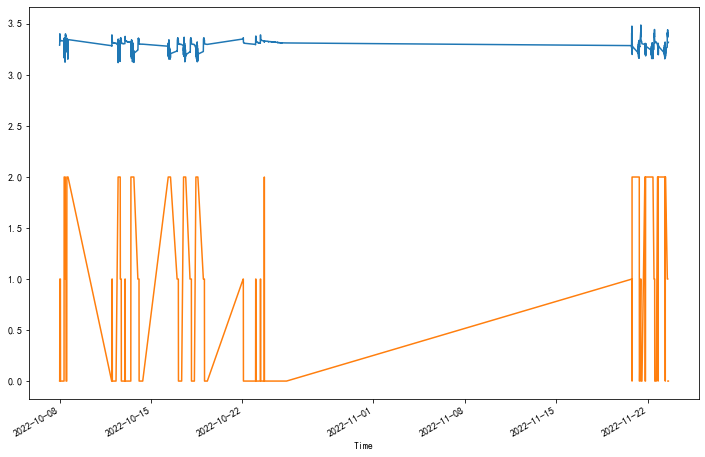

In [7]:
# 数据清洗, 训练数据准备
%matplotlib inline
df = pd.read_csv(r'.\data\AI_test_data.csv', header=0)     #csv
df.drop_duplicates('Time',keep='last',inplace=True)           # 删除重复时间数据
pd.to_datetime(df['Time'])
df.index=pd.to_datetime(df['Time'])
df.drop(labels=['Time'], axis=1, inplace = True)       # 去掉Time列
# df['s1_v1'].dropna(inplace=True)                                # 删除空值行

df = df.sort_index(ascending=True)                     # 时间顺序排序
 
# df['state'].astype('int')
# df.drop(df.tail(4000).index, inplace=True)
df['s1_v1'].plot(legend=None,figsize=(12,8)) 
df['state'].plot()
dataset = df.copy()


In [8]:
# 超参数设置
window_size = 16   # 窗口大小
batch_size = 32    # 训练批次大小
epochs = 100       # 训练epoch
filter_nums = 12   # filter数量
kernel_size = 4    # kernel大小


#### 2. train  and   test 划分

In [9]:
# 对数据划分数据集和测试集
columns = ['s1_v1']                                             # 标签也需要归一化
for col in columns:
    scaler = MinMaxScaler()
    dataset[col] = scaler.fit_transform(dataset[col].values.reshape(-1,1))

X = dataset['s1_v1']
Y = dataset['state']

# 划分训练集 测试集
x_train, x_test,y_train,y_test = train_test_split(X, Y, test_size=0.4, shuffle = False, random_state = 666)

def create_dataset(X, Y, seq_len=5):             
    featrues = []
    targets = []
    
    for i in range(0,len(X)-seq_len,seq_len):
        data = X.iloc[i:i+seq_len]
        label = Y.iloc[i]                                                              # 犯过错误 label = Y.iloc[i:i+seq_len] 
        
        featrues.append(data)
        targets.append(label)
        
    return np.array(featrues), np.array(targets)

train_dataset, train_labels = create_dataset(x_train, y_train, seq_len=window_size)            # 构建训练数据集
test_dataset, test_labels = create_dataset(x_test, y_test, seq_len=window_size)                # 构建测试数据集

In [13]:
train_labels = tf.one_hot(indices=train_labels,depth=3)                       # 转化为one_hot数组
test_labels_onehot = tf.one_hot(indices=test_labels,depth=3)

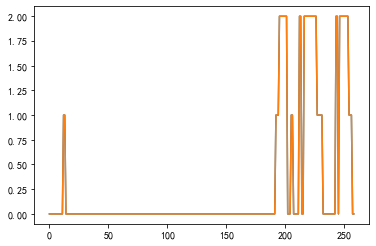

In [17]:
plt.plot(test_labels)
plt.plot(np.argmax(test_labels_onehot, axis=1))

#### 3. 搭建TCN模型、训练模型

In [18]:
model = keras.models.Sequential([
        keras.layers.Input(shape=(window_size, 1)),
        TCN(nb_filters=filter_nums,                   # 滤波器的个数，类比于units
            kernel_size=kernel_size,                   # 卷积核的大小
            dilations=[1, 2, 4, 8]),     # 空洞因子
        keras.layers.Dense(units=3, activation='softmax')
    ])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn (TCN)                   (None, 12)                4200      
                                                                 
 dense (Dense)               (None, 3)                 39        
                                                                 
Total params: 4,239
Trainable params: 4,239
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
10/10 [==============================] - 1s 28ms/step - loss: 2.4771 - mae: 0.4998 - val_loss: 1.5444 - val_mae: 0.4902
Epoch 2/100
10/10 [==============================] - 0s 4ms/step - loss: 1.1553 - mae: 0.4032 - val_loss: 0.9306 - val_mae: 0.3222
Epoch 3/100
10/10 [==============================] - 0s 5ms/step - loss: 0.9497 - mae: 0.3295 - val_loss: 0.8431 - val_mae: 0.3157
Epoch 4/100
10/10 [==============================] - 0s 5ms/step - loss: 0.8978 - mae: 0.3577 - val_loss: 0.8118 - val_mae: 0.3396
Epoch 5/100
10/10 [==============================] - 0s 5ms/step - loss: 0.8600 - mae: 0.3440 - val_loss: 0.7788 - val_mae: 0.3157
Epoch 6/100
10/10 [==============================] - 0s 5ms/step - loss: 0.8306 - mae: 0.3361 - val_loss: 0.7686 - val_mae: 0.3247
Epoch 7/100
10/10 [==============================] - 0s 5ms/step - loss: 0.7932 - mae: 0.3262 - val_loss: 0.7371 - val_mae: 0.2927
Epoch 8/100
10/10 [==============================] - 0s 5ms/step - loss: 0.7755 - 

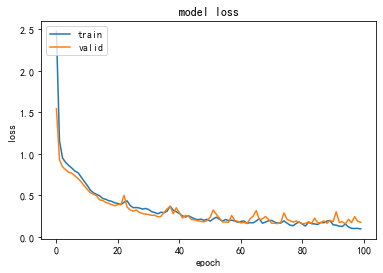

In [19]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['mae'])
history = model.fit(train_dataset, train_labels, validation_split=0.2, epochs=epochs)

# scores = model.evaluate(x_test, y_test, verbose=0)
# print("Accuracy: %.2f%%" % (scores[1]*100))
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig('./loss.png')

#### 4. 使用模型做出预测

9/9 [==============================] - 0s 875us/step
RMSE  0.10754440584149062
准确度为： 0.9498069498069498


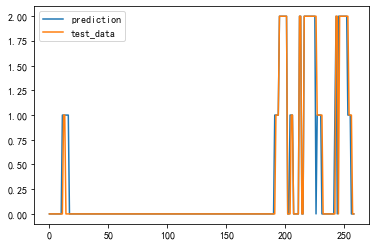

In [31]:
def RMSE(pred, true):
    return np.sqrt(np.mean(np.square(pred - true)))

model.evaluate(test_dataset, test_labels_onehot)
prediction = model.predict(test_dataset)
prediction = np.argmax(prediction, axis=1)
scaled_prediction = scaler.inverse_transform(prediction.reshape(-1, 1)).reshape(-1)
scaled_test_label = scaler.inverse_transform(np.argmax(test_labels_onehot, axis=1).reshape(-1, 1)).reshape(-1)
print('RMSE ', RMSE(scaled_prediction, scaled_test_label))
plt.plot(prediction)
plt.plot(test_labels)
plt.legend(['prediction','test_data'])
np.set_printoptions(precision=4, threshold=np.inf)
test_true = np.argmax(test_labels_onehot,axis=1)
accuracy = sum(prediction == test_true)/len(prediction)      # 准确度
print("准确度为：", str(accuracy))

准确度为 0.9525986525505293


Text(0, 0.5, 'Current State')

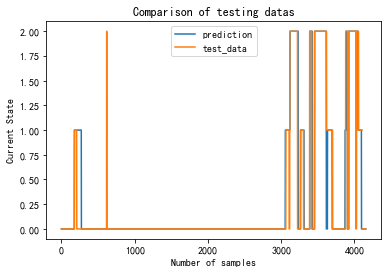

In [33]:
# decoder  解码

def decoder(pre, Y):
    Y_prediction=[]
    for i in range(len(pre)):
        for j in range(window_size):
            Y_prediction.append(pre[i])
    
    for k in range(len(Y)-len(pre)*window_size):
        Y_prediction.append(pre[len(pre)-1])
        
    return np.array(Y_prediction)
        
test_prediction1 = decoder(prediction, y_test)
accuracy1 = sum(test_prediction1 == y_test)/len(test_prediction1)      # 准确度
print('准确度为', accuracy1)
plt.plot(test_prediction1)
plt.plot(y_test.values)
plt.legend(['prediction','test_data'])
plt.title('Comparison of testing datas')
plt.xlabel('Number of samples')
plt.ylabel('Current State')
# plt.savefig('./test_data.png')

#### 5. 模型保存

In [32]:
# save model
# model.save("./model3.hdf5")

#### 6. 模型应用

In [34]:
df1 = pd.read_csv(r'.\data\湘A02183D_2022-11-23T14_15_37.737.csv', header=0)
model = keras.models.load_model("model3.hdf5", compile = False, custom_objects={'TCN':TCN})

# 封装 数据预处理
def data_read(df):
    df.drop_duplicates('Time',keep='last',inplace=True)           # 删除重复时间数据
    pd.to_datetime(df['Time'])
    df.index=pd.to_datetime(df['Time'])
    df.drop(labels=['Time'], axis=1, inplace = True)       # 去掉Time列
    df.dropna(inplace=True)                                # 删除空值行
    df = df.sort_index(ascending=True)                     # 时间顺序排序
    # df.drop(df.tail(4000).index, inplace=True)           # 删除数据
    data_set = df.copy()
    return data_set

data1 = data_read(df1)
# data1.drop(['state'], axis=1,inplace=True)
data1

,s1_v1,s1_v2,s1_v3,s1_v4,s1_v5,s1_v6,s1_v7,s1_v8,s1_v9,s1_v10,...,s7_v15,s7_v16,s7_v17,s7_v18,s7_v19,s7_v20,s7_v21,s7_v22,s7_v23,s7_v24
Time,,,,,,,,,,,,,,,,,,,,,
2022-11-07 12:06:37,3.334,3.333,3.333,3.330,3.333,3.332,3.334,3.333,3.333,3.331,...,3.336,3.337,3.337,3.337,3.336,3.337,3.337,3.337,3.335,3.337
2022-11-07 12:07:36,3.334,3.333,3.332,3.330,3.333,3.332,3.334,3.333,3.332,3.331,...,3.336,3.337,3.337,3.337,3.336,3.337,3.337,3.337,3.335,3.337
2022-11-07 12:08:07,3.334,3.333,3.332,3.330,3.333,3.332,3.333,3.333,3.332,3.331,...,3.336,3.337,3.337,3.337,3.336,3.337,3.337,3.337,3.335,3.337
2022-11-07 12:08:37,3.334,3.333,3.332,3.330,3.333,3.332,3.334,3.333,3.332,3.330,...,3.336,3.337,3.337,3.337,3.336,3.337,3.337,3.337,3.335,3.337
2022-11-07 12:09:07,3.334,3.333,3.332,3.330,3.333,3.332,3.334,3.333,3.332,3.331,...,3.336,3.337,3.337,3.336,3.336,3.337,3.337,3.337,3.335,3.337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-23 14:00:12,3.322,3.321,3.322,3.321,3.321,3.321,3.323,3.322,3.321,3.321,...,3.326,3.327,3.327,3.326,3.326,3.328,3.327,3.327,3.327,3.328
2022-11-23 14:00:42,3.322,3.322,3.322,3.321,3.321,3.321,3.323,3.322,3.321,3.322,...,3.326,3.327,3.327,3.326,3.326,3.328,3.327,3.327,3.327,3.328
2022-11-23 14:01:12,3.321,3.321,3.321,3.322,3.321,3.321,3.323,3.322,3.321,3.321,...,3.326,3.327,3.327,3.326,3.326,3.327,3.327,3.327,3.327,3.328


In [43]:
# 封装 归一化和数据集划分
def data_process(dataset, columns = ['s1_v1']):         # 电池数可添加                                  
    for col in columns:                                 # 数据归一化
        scaler = MinMaxScaler()
        dataset[col] = scaler.fit_transform(dataset[col].values.reshape(-1,1))
        
    X = dataset[columns]
    return X

X = data_process(data1)


In [37]:
# 数据进行预测
window_size=12
Y_test = pd.DataFrame([],index=X.index)
train_dataset1, train_labels1 = create_dataset(X, Y_test, seq_len=window_size)

prediction1 = model.predict(train_dataset1)
prediction1 = np.argmax(prediction1, axis=1)

28/28 [==============================] - 0s 1000us/step


Text(0.5, 0, 'Time')

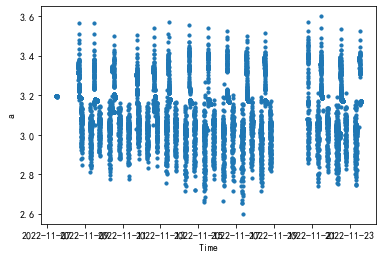

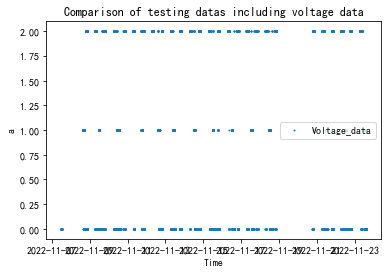

In [41]:
test_prediction1 = decoder(prediction1, X)
data_test1 = pd.DataFrame(X.values+2.6, index=range(len(data1.index)),columns=['a'])
data_test1['Time'] = data1.index
data_prediction1 = pd.DataFrame(test_prediction1, index=range(len(data1.index)),columns=['a'])
data_prediction1['Time'] = data1.index
# plt.plot.scatter(pd.DataFrame(X.values+2.6, index=data1.index))
# plt.plot(pd.DataFrame(test_prediction1, index=data1.index))
data_test1.plot.scatter(x='Time',y='a',s=10)
data_prediction1.plot.scatter(x='Time',y='a',s=1)
plt.legend(['Voltage_data','prediction_data'])
plt.title('Comparison of testing datas including voltage data')
plt.xlabel('Time')
# plt.ylabel('Current State')
# plt.savefig('./test_data1.png')

#### 附：显示模型结构

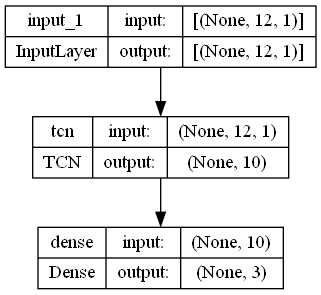

In [42]:
from keras.utils.vis_utils import plot_model
# model = keras.models.load_model("model4.hdf5", compile = False, custom_objects={'TCN':TCN})
keras.utils.plot_model(model, to_file='graph.png', show_shapes=True)